In [1]:
import pandas as pd
df = pd.read_csv('train_data.csv')
df.head()

,Unnamed: 0,title,category
0,0,Nearly Natural 5195 Fancy Style Bamboo Silk Tr...,Home & Kitchen
1,1,Mud Pie Acorn Cutting Board &amp; Dip Set,None
2,2,Decorative Pair of Square Arm Caps Floral Embr...,None
3,3,Disney Frozen Pencil Case/Cosmetic Bag with St...,Office Products
4,4,Essentials D&eacute;cor Entrada Collection Met...,None


In [2]:
df.iloc[3]

Unnamed: 0                                                    3
title         Disney Frozen Pencil Case/Cosmetic Bag with St...
category                                        Office Products
Name: 3, dtype: object

In [3]:
df['category_id'] = df['category'].factorize()[0]
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)


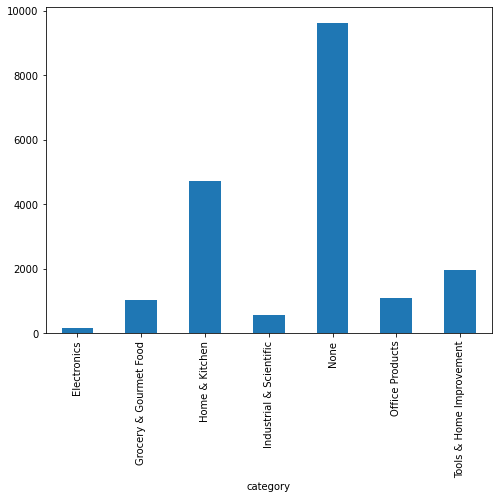

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('category').title.count().plot.bar(ylim=0)
plt.show()

In [5]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Lets do some text cleanup
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
REMOVE_NUM = re.compile('[\d+]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    text: a string
    return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = text.replace('x', '') # Remove the XXXX values
    text = REMOVE_NUM.sub('', text)
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text
    
df["title"] = df["title"].apply(clean_text)

[nltk_data] Downloading package stopwords to /Users/anuj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
from sklearn.model_selection import train_test_split, cross_val_score

x = df["title"]
y = df["category_id"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv2 = TfidfVectorizer(sublinear_tf= True, min_df=10, norm='l2', ngram_range=(1, 2), stop_words='english')

X_traincv = cv2.fit_transform(x_train)
x_testcv = cv2.transform(x_test)
print(X_traincv.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# ignore ConvergenceWarnings
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

models = [
    { "estimater": KNeighborsClassifier(),
      "params": {
          "n_neighbors": [25,30,35,45],
          "weights": ['uniform','distance'],
          "leaf_size": [25,30,35]
        }
    },
    { "estimater": DecisionTreeClassifier(),
      "params": {
          "criterion": ['gini','entropy'],
          "splitter": ['best','random'],
          "max_depth": [None,90,95,100],
          "max_features": [None, "auto","sqrt","log2"],
          "random_state": [42]
      }
    },
    { "estimater": MultinomialNB(),
      "params": {
          "fit_prior": [True, False]    
      }
    },
    { "estimater": LinearSVC(),
      "params": {
          "loss": ['hinge','squared_hinge'],
          "multi_class": ['ovr', 'crammer_singer'],
          "fit_intercept": [True, False],
          "random_state": [42],
          "max_iter": [900, 1000, 1100]
      }
    },
    { "estimater": RandomForestClassifier(),
      "params": {
      "criterion": ['gini','entropy'],
      "bootstrap": [True, False],
      "max_depth": [85,90,95,100],
      "max_features": ['sqrt','log2'],
      "n_estimators": [60, 80, 90],
      "random_state": [42]
      }
    },
    { "estimater": SGDClassifier(),
      "params": {
          "loss": ['hinge','log','perceptron'], 
          "penalty": ['l2', 'l1'], 
          "alpha": [0.0001, 0.0003, 0.0010],
          "early_stopping": [True],
          "max_iter": [1000, 1500],
          "random_state": [42]
      }
    }
]

column_names = ["KNeighbors", "DecisionTree", "MultiNB", "SVC", "RFC", "SGDClassifier"]
entries = []

highest_acc = 0
best_model = None

for model in models:
  print(model["estimater"])

  # Create a based model
  clf = model["estimater"]
  # Instantiate the grid search model
  grid_search = GridSearchCV(estimator = clf, param_grid = model["params"], 
                            cv = 3, n_jobs = 1)
  # Fit the model
  grid_search.fit(X_traincv, y_train);

  # Make a prediction on the test split to find model accuracy
  predicted = grid_search.predict(x_testcv)
  acc = accuracy_score(predicted, y_test)
  entries.append(acc)

  print(grid_search.best_params_)

  # If model have the highest accuracy, it's out best model
  if acc > highest_acc:
    highest_acc = acc
    best_model = grid_search

KNeighborsClassifier()
{'leaf_size': 25, 'n_neighbors': 45, 'weights': 'uniform'}
DecisionTreeClassifier()
{'criterion': 'gini', 'max_depth': 95, 'max_features': 'log2', 'random_state': 42, 'splitter': 'best'}
MultinomialNB()
{'fit_prior': True}
LinearSVC()
{'fit_intercept': True, 'loss': 'hinge', 'max_iter': 900, 'multi_class': 'ovr', 'random_state': 42}
RandomForestClassifier()
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 90, 'max_features': 'sqrt', 'n_estimators': 60, 'random_state': 42}
SGDClassifier()
{'alpha': 0.0003, 'early_stopping': True, 'loss': 'log', 'max_iter': 1000, 'penalty': 'l2', 'random_state': 42}


       Estimater  Accuracy
0     KNeighbors  0.505996
1   DecisionTree  0.485401
2        MultiNB  0.496090
3            SVC  0.476538
4            RFC  0.503650
5  SGDClassifier  0.506778


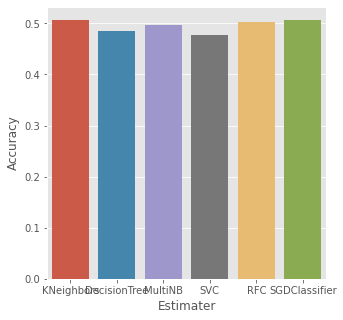

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(5, 5))

df1 = pd.DataFrame({"Estimater": column_names, 
                   "Accuracy": entries
                  })

sns.barplot(x='Estimater', y='Accuracy', data=df1)

print(df1)

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

In [11]:
predicted = best_model.predict(x_testcv)
evaluate_preds(y_test, predicted)

Acc: 50.68%
Precision: 0.51
Recall: 0.51
F1 score: 0.51


{'accuracy': 0.51, 'precision': 0.51, 'recall': 0.51, 'f1': 0.51}

In [12]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted, 
                                    target_names=df['category'].unique()))

                          precision    recall  f1-score   support

          Home & Kitchen       0.51      0.10      0.16       926
                    None       0.51      0.95      0.66      1942
         Office Products       0.00      0.00      0.00       186
Tools & Home Improvement       0.31      0.01      0.02       417
 Industrial & Scientific       0.00      0.00      0.00       108
  Grocery & Gourmet Food       0.53      0.04      0.08       218
             Electronics       0.00      0.00      0.00        39

                accuracy                           0.51      3836
               macro avg       0.27      0.16      0.13      3836
            weighted avg       0.44      0.51      0.38      3836



/Users/anuj/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anuj/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anuj/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


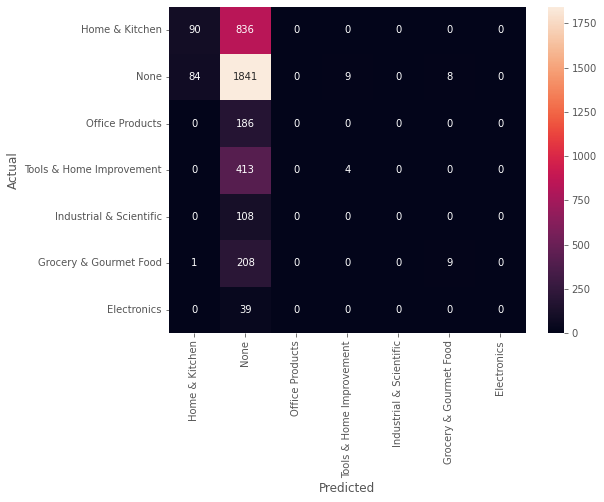

In [13]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=df.category.unique(), yticklabels=df.category.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [14]:
uniques = df.drop('title', axis=1)
unique_labels = uniques.drop_duplicates()
unique_labels

,Unnamed: 0,category,category_id
0,0,Home & Kitchen,0
1,1,None,1
2,2,None,1
3,3,Office Products,2
4,4,None,1
...,...,...,...
19173,19173,Industrial & Scientific,4
19174,19174,Tools & Home Improvement,3
19175,19175,Home & Kitchen,0
19176,19176,Grocery & Gourmet Food,5


In [15]:
import numpy as np
inputStr = cv2.transform(["Disney Princess Insulated Lunch Bag - Lunch Box"])
results = best_model.predict(inputStr )

print(f'category id: {results[0]}')
print(f'category Name: { np.asarray(unique_labels[unique_labels.category_id.eq(results[0])])[0][1] }')



category id: 0
category Name: Home & Kitchen


In [16]:
df3=pd.read_csv('test_data.csv')

In [17]:
df3.head()

,Unnamed: 0,title
0,0,SnapWords List F Pocket Chart Cards - Sight Words
1,1,RESTOR Style Signature Cool Comfort Memory Foa...
2,2,Solder SILVER SOLDER PASTE (1 piece)
3,3,Entertaining with Caspari Father Christmas 5&q...
4,4,BISSELL CleanView Complete Pet Rewind Bagless ...


In [18]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Lets do some text cleanup
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
REMOVE_NUM = re.compile('[\d+]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    text: a string
    return: modified initial string
    """
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = text.replace('x', '')
    text = REMOVE_NUM.sub('', text)
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
    
df3["title"] = df3["title"].apply(clean_text)

[nltk_data] Downloading package stopwords to /Users/anuj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
import pickle

In [24]:
with open('model_pickle','wb') as file:
    pickle.dump(model,file)

In [25]:
with open('model_pickle','rb') as file:
    mp = pickle.load(file)